In [1]:
import os
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt
import gc
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [2]:
input_label = []
output_label = []

In [3]:
a,b = 0,0

ficheiro = open("..\\..\\..\\DatasetTratado\\02-03-2018.csv", "r")

ficheiro.readline()
ficheiro.readline()
ficheiro.readline()
linha = ficheiro.readline()
while(linha != ""):
    linha = linha.split(",")
    out = linha.pop(37)
    if(out == "Benign"): 
        out = 0
        b += 1
    else: 
        out = 1
        a += 1
    output_label.append(out)
    input_label.append(linha)
    linha = ficheiro.readline()
ficheiro.close()
print(str(a) + " " + str(b))

286191 758334


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [5]:
backup_input_label = input_label[:]
backup_output_label = output_label[:]

<h2>PCA</h2>

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=18)

In [8]:
pca.fit(input_label)

PCA(n_components=18)

In [9]:
x_pca = pca.transform(input_label)

In [10]:
input_label.shape

(1044525, 78)

In [11]:
x_pca.shape

(1044525, 18)

In [12]:
x_pca = x_pca.reshape(len(x_pca), 18, 1)
y_pca = np.array(output_label)

In [13]:
x_pca, y_pca = shuffle(x_pca, y_pca)

In [14]:
backup_input_label = x_pca[:]
backup_output_label = y_pca[:]

<h2>Cross Validation</h2>

In [15]:
confusion_matrixs = []
roc_curvs = []

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [17]:
for i in range(10):
    mini = int(len(x_pca) * 0.10) * i
    maxi = int((len(x_pca) * 0.10) * (i + 1))
    
    inp_train = np.array([*x_pca[0: mini],*x_pca[maxi:len(x_pca)]])
    inp_test = np.array(x_pca[mini: maxi])
    out_train = np.array([*y_pca[0: mini],*y_pca[maxi:len(y_pca)]])
    out_test = np.array(y_pca[mini:maxi])
    
    
    model = keras.Sequential([
        layers.Input(shape = (18,1)),
        layers.Conv1D(filters = 16, kernel_size = 3, padding = "same", activation = "relu", use_bias = True),
        layers.MaxPool1D(pool_size = 3),
        layers.Conv1D(filters = 8, kernel_size = 3, padding = "same", activation = "relu", use_bias = True),
        layers.MaxPool1D(pool_size = 3),
        layers.Flatten(),
        layers.Dense(units = 2, activation = "softmax")
    ])
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.00025), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    treino = model.fit(x = inp_train, y = out_train, validation_split= 0.1, epochs = 10, shuffle = True,verbose = 0)
    
    res = np.array([np.argmax(resu) for resu in model.predict(inp_test)])
    
    confusion_matrixs.append(confusion_matrix(out_test, res))
    fpr, tpr, _ = roc_curve(out_test,  res)
    auc = roc_auc_score(out_test, res)
    roc_curvs.append([fpr, tpr, auc])

<h2>Roc Curves</h2>

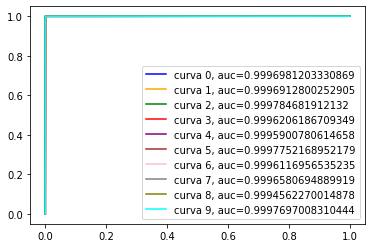

In [18]:
cores = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
for i in range(10):
    plt.plot(roc_curvs[i][0],roc_curvs[i][1],label="curva " + str(i) + ", auc=" + str(roc_curvs[i][2]), c = cores[i])
plt.legend(loc=4)
plt.show()

In [19]:
total_conv_matrix = [[0,0],[0,0]]
for cov in confusion_matrixs:
    total_conv_matrix[0][0] += cov[0][0] 
    total_conv_matrix[0][1] += cov[0][1]
    total_conv_matrix[1][0] += cov[1][0]
    total_conv_matrix[1][1] += cov[1][1]


In [20]:
def plot_confusion_matrix(cm, classes, normaliza = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normaliza:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[758078    274]
 [    88 286105]]


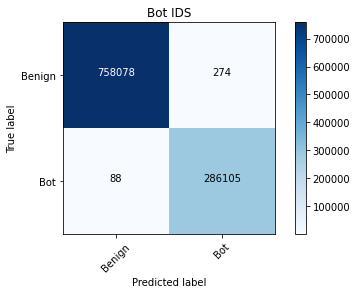

In [21]:
labels = ["Benign", "Bot"]
plot_confusion_matrix(cm = np.array(total_conv_matrix), classes = labels, title = "Bot IDS")